<a href="https://colab.research.google.com/github/AusafMo/Audio-Fingerprinting-Demo/blob/main/TorchAudio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

SpectroGram

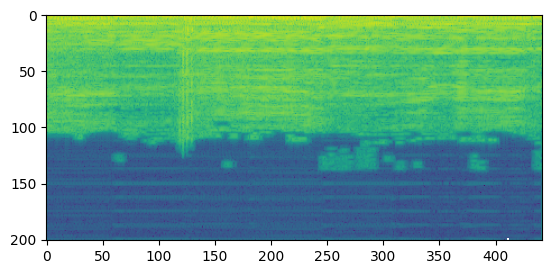

In [ ]:
import torch
import torchaudio

# Load the audio waveform
waveform, sample_rate = torchaudio.load("/content/nasheed.mp3")

# Calculate the duration of the audio clip in seconds
duration = waveform.shape[1] / sample_rate

# Trim the audio clip to the desired duration
trim_duration = 2  # in seconds
trim_samples = int(trim_duration * sample_rate)
start_sample = (waveform.shape[1] - trim_samples) // 2
end_sample = start_sample + trim_samples
trimmed_waveform = waveform[:, start_sample:end_sample]

# Create the spectrogram transform
spec_transform = torchaudio.transforms.Spectrogram()

# Apply the transform to the trimmed waveform
spectrogram = spec_transform(trimmed_waveform)

# Show the spectrogram
import matplotlib.pyplot as plt
plt.imshow(spectrogram.log2()[0,:,:].numpy(), cmap='viridis')


Fingerprinting

For the registering the Database fingerprint

In [ ]:
import torchaudio
import numpy as np
from scipy.signal import find_peaks
import json

# Load the audio sample
waveform, sample_rate = torchaudio.load('/content/nasheed.mp3')

# Extract the spectrogram
spectrogram = torchaudio.transforms.Spectrogram()(waveform).numpy()

# Identify the spectral peaks
max_values = []
for col in range(spectrogram.shape[1]):
    max_values.append(np.max(spectrogram[:,col]))

peak_indices = find_peaks(max_values, distance=2, threshold=None)[0]

# Convert the indices to pairs
bins = np.digitize(peak_indices, np.arange(0, spectrogram.shape[1]))
pairs = [(bins[i], peak_indices[i] % spectrogram.shape[1]) for i in range(len(peak_indices))]

# Group the pairs by bin and sort them by time index
landmarks = {}
for pair in pairs:
    if pair[0] not in landmarks:
        landmarks[pair[0]] = []
    landmarks[pair[0]].append(pair[1])
for bin in landmarks:
    landmarks[bin] = sorted(landmarks[bin])

# Convert NumPy integers to Python integers
landmarks = {int(k): [int(x) for x in v] for k, v in landmarks.items()}

# Hash the landmarks
fingerprint1 = hash(json.dumps(landmarks, sort_keys=True).encode())

# Store the fingerprint in a dictionary with metadata
database = {'audio_sample.wav': {'fingerprint': fingerprint1, 'artist': 'XYZ', 'title': 'ABC'}}
print(database)

{'audio_sample.wav': {'fingerprint': 4782747566755052229, 'artist': 'XYZ', 'title': 'ABC'}}


Recording

In [ ]:
# !pip install sounddevice
# !apt-get install -y python3-pyaudio
# !pip install ffmpeg-python

In [ ]:
from scipy.io.wavfile import read as wav_read, write as wav_write

In [ ]:
# ISKA CODE : https://colab.research.google.com/gist/ricardodeazambuja/03ac98c31e87caf284f7b06286ebf7fd/microphone-to-numpy-array-from-your-browser-in-colab.ipynb#scrollTo=rRhs_YyomPQh

from IPython.display import HTML, Audio
from google.colab.output import eval_js
from base64 import b64decode
import numpy as np
from scipy.io.wavfile import read as wav_read
import io
import ffmpeg

AUDIO_HTML = """
<script>
var my_div = document.createElement("DIV");
var my_p = document.createElement("P");
var my_btn = document.createElement("BUTTON");
var t = document.createTextNode("Press to start recording");

my_btn.appendChild(t);
//my_p.appendChild(my_btn);
my_div.appendChild(my_btn);
document.body.appendChild(my_div);

var base64data = 0;
var reader;
var recorder, gumStream;
var recordButton = my_btn;

var handleSuccess = function(stream) {
  gumStream = stream;
  var options = {
    //bitsPerSecond: 8000, //chrome seems to ignore, always 48k
    mimeType : 'audio/webm;codecs=opus'
    //mimeType : 'audio/webm;codecs=pcm'
  };
  //recorder = new MediaRecorder(stream, options);
  recorder = new MediaRecorder(stream);
  recorder.ondataavailable = function(e) {
    var url = URL.createObjectURL(e.data);
    var preview = document.createElement('audio');
    preview.controls = true;
    preview.src = url;
    document.body.appendChild(preview);

    reader = new FileReader();
    reader.readAsDataURL(e.data);
    reader.onloadend = function() {
      base64data = reader.result;
      //console.log("Inside FileReader:" + base64data);
    }
  };
  recorder.start();
  };

recordButton.innerText = "Recording... press to stop";

navigator.mediaDevices.getUserMedia({audio: true}).then(handleSuccess);


function toggleRecording() {
  if (recorder && recorder.state == "recording") {
      recorder.stop();
      gumStream.getAudioTracks()[0].stop();
      recordButton.innerText = "Saving the recording... pls wait!"
  }
}

// https://stackoverflow.com/a/951057
function sleep(ms) {
  return new Promise(resolve => setTimeout(resolve, ms));
}

var data = new Promise(resolve=>{
//recordButton.addEventListener("click", toggleRecording);
recordButton.onclick = ()=>{
toggleRecording()

sleep(2000).then(() => {
  // wait 2000ms for the data to be available...
  // ideally this should use something like await...
  //console.log("Inside data:" + base64data)
  resolve(base64data.toString())

});

}
});

</script>
"""

def get_audio():
  display(HTML(AUDIO_HTML))
  data = eval_js("data")
  binary = b64decode(data.split(',')[1])

  process = (ffmpeg
    .input('pipe:0')
    .output('pipe:1', format='wav')
    .run_async(pipe_stdin=True, pipe_stdout=True, pipe_stderr=True, quiet=True, overwrite_output=True)
  )
  output, err = process.communicate(input=binary)

  riff_chunk_size = len(output) - 8
  # Break up the chunk size into four bytes, held in b.
  q = riff_chunk_size
  b = []
  for i in range(4):
      q, r = divmod(q, 256)
      b.append(r)

  # Replace bytes 4:8 in proc.stdout with the actual size of the RIFF chunk.
  riff = output[:4] + bytes(b) + output[8:]

  sr, audio = wav_read(io.BytesIO(riff))

  return audio, sr

Calls the get_audio() above and saves it in the current directory

In [ ]:
import os

audio, sr = get_audio()
filename = "songTest5.wav" # You can choose any name for the file
filepath = os.path.join(os.getcwd(), filename)
wav_write(filepath, sr, audio)

In [ ]:
import torchaudio
import numpy as np
from scipy.signal import find_peaks
import json

filename = 'nasheed.mp3'
# Load the audio sample
waveform, sample_rate = torchaudio.load(f'/content/{filename}')

# Extract the spectrogram
spectrogram = torchaudio.transforms.Spectrogram()(waveform).numpy()

# Identify the spectral peaks
max_values = []
for col in range(spectrogram.shape[1]):
    max_values.append(np.max(spectrogram[:,col]))

peak_indices = find_peaks(max_values, distance=2, threshold=None)[0]

# Convert the indices to pairs
bins = np.digitize(peak_indices, np.arange(0, spectrogram.shape[1]))
pairs = [(bins[i], peak_indices[i] % spectrogram.shape[1]) for i in range(len(peak_indices))]

# Group the pairs by bin and sort them by time index
landmarks = {}
for pair in pairs:
    if pair[0] not in landmarks:
        landmarks[pair[0]] = []
    landmarks[pair[0]].append(pair[1])
for bin in landmarks:
    landmarks[bin] = sorted(landmarks[bin])

# Convert NumPy integers to Python integers
landmarks = {int(k): [int(x) for x in v] for k, v in landmarks.items()}

# Hash the landmarks
fingerprint2 = hash(json.dumps(landmarks, sort_keys=True).encode())


{'audio_sample.wav': {'fingerprint': 4782747566755052229, 'artist': 'Unknown', 'title': 'Unknown'}}


In [ ]:
if fingerprint1 == fingerprint2 :
  print(f"The song name is {database['audio_sample.wav']['title']}.")
else :
  print('The songs are not the same.')

The song name is ABC.
